In [1]:
import pandas as pd
import numpy as np
from support_fun import corruption, RMSE, draw
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the data
df = pd.read_excel('Dataset_RTsRTWINWeather_2018.xlsx', engine='openpyxl')[['timestamp', 'RoomTemperatureRT']]

In [3]:
# Set timestamp column to index
df.set_index('timestamp', inplace=True)

In [4]:
print(df.head()) #debugging

                     RoomTemperatureRT
timestamp                             
2018-05-20 00:00:00          23.584482
2018-05-20 00:01:00          23.586210
2018-05-20 00:02:00          23.584482
2018-05-20 00:03:00          23.581122
2018-05-20 00:04:00          23.576131


In [5]:
# Resample to 30 min
df_30min = df.asfreq(freq='30T')

/tmp/ipykernel_38743/4124092362.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min = df.asfreq(freq='30T')


In [6]:
# Remove nan values
df_30min.dropna(inplace=True)

In [7]:
# Get the timestamp index as an array
timestamp = df_30min.index.values

In [8]:
# Convert room temperature column to numpy
data_column = df_30min['RoomTemperatureRT'].values

In [9]:
# Reshape room temperature array to a day-to-day matrix
data = np.reshape(data_column, (int(data_column.shape[0] / 48), 48))

In [10]:
# Corrupt daily input data with a predefined corruption rate [0-1] and missing scenario [continuous/random]. Use the prede
data_corrupted_nan, mask = corruption(input=data, corruption_rate=0.4, missing_scenario='continuous')

inp type float64


In [11]:
# Create a CustomStandardScaler object to normalize the data with Z-score
scaler = StandardScaler()

In [12]:
# Fit the scaler to the dataset and transform it
data_normalized = scaler.fit_transform(data)

In [13]:
# Replace nan values with zeros for modeling
data_corrupted_normalized = data_normalized.copy()
data_corrupted_normalized[mask] = 0.0

In [14]:
# Insert hyperparameters
input_size  = 48
hidden_size = 24
lr     = 0.01
epochs = 5000

In [15]:
# Initialize weights and bias
W1 = np.random.randn(input_size,  hidden_size) * 0.01           # (48, 24)
b1 = np.zeros((1, hidden_size))  * 0.01                         # (1, 24)
W2 = np.random.randn(hidden_size, input_size)   * 0.01          # (24, 48)
b2 = np.zeros((1, input_size))   * 0.01                         # (1, 48)


In [16]:
# Define a function for forward pass forward(X)
def forward(X):
    
    # encoder
    Z1 = X @ W1 + b1
    # activation function on linear output of encoder
    A1 = np.tanh(Z1)
    # decoder
    Y = A1 @ W2 + b2
    return Z1, A1, Y

In [17]:
# Loss function
def loss_fn(X, Y):
    
    MSE = np.mean(np.square(Y - X))
    return MSE

In [18]:
# Backward pass. Use @ for matrix multiplications, use * for matrices of same shapes
def backward(X, Z1, A1, Y):

    # tot number of elements
    m = X.size

    # compute single derivatives: d[x]_d[y] --> derivative of x with respect to y

    dL_dY = 2 * (Y - X) / m                             #(170,48)
    #print("dL_dY", dL_dY.shape)
    dY_dW2 = A1                                         #(170,24)
    #print("dY_dW2", dY_dW2.shape)
                  
    dY_dA1 = W2                                         #(24, 48)
    #print("dY_dA1", dY_dA1.shape)
    dA1_dZ1 = 1 - np.tanh(Z1)**2                        #(170, 24)
    #print("dA1_dZ1", dA1_dZ1.shape)
    dZ1_dW1 = X                                         #(170, 48)
    #print("dZ1_dW1", dZ1_dW1.shape)

    # apply chain rule, using single derivatives, to obtain the requested outputs.
    # hint: check for shape consistency (print("dL_dY", dL_dY.shape))
    # hint: use traspose (T) when needed, e.g. (170,24).T @ (170,48) = (24,170) @ (170,48) = (24,48)
    dL_dW2 = dY_dW2.T @ dL_dY                           #(24,170)*(170,48)=(24,48)
    dL_db2 = dL_dY.sum(axis=0, keepdims=True)           #(1,48)

    dL_dY_dZ1_dW1 = dL_dY * dZ1_dW1                     #(170,48)*(170,48)=(170,48)
    dL_dY_dZ1_dW1_T_dA1_dZ1 = dL_dY_dZ1_dW1.T @ dA1_dZ1 #(48,170)*(170,24)=(48,24)
    dL_dW1 = dL_dY_dZ1_dW1_T_dA1_dZ1 * dY_dA1.T         #(48,24)*(48,24)= (48,24)
    
    dL_dW1 = dZ1_dW1.T @ ((dL_dY @ dY_dA1.T) * dA1_dZ1) #(48, 24)

    dL_dY_T_dA1_dZ1 = dL_dY.T @ dA1_dZ1                 #(48,170)*(170,24)=(48,24)
    dL_db1_ = dL_dY_T_dA1_dZ1 * dY_dA1.T                #(48,24)*(48,24)= (48,24)

    dL_db1 = dL_db1_.sum(axis=0, keepdims=True)         #(1,24)
    
    return dL_dW2, dL_db2, dL_dW1, dL_db1

In [19]:
# Training loop

for ep in range(epochs):

    # forward pass
    Z1, A1, Y = forward(data_corrupted_normalized)

    # loss function
    loss = loss_fn(data_normalized, Y)

    # Backward pass
    dL_dW2, dL_db2, dL_dW1, dL_db1 = backward(data_normalized, Z1, A1, Y)

    # Gradient‑descent step
    W1 -= lr * dL_dW1
    b1 -= lr * dL_db1
    W2 -= lr * dL_dW2
    b2 -= lr * dL_db2

    if (ep + 1) % 100 == 0:
        print(f"Epoch {ep+1}/{epochs} – loss {loss:.4f}")

Epoch 100/5000 – loss 0.9891
Epoch 200/5000 – loss 0.9479
Epoch 300/5000 – loss 0.8517
Epoch 400/5000 – loss 0.7233
Epoch 500/5000 – loss 0.6161
Epoch 600/5000 – loss 0.5517
Epoch 700/5000 – loss 0.5196
Epoch 800/5000 – loss 0.5039
Epoch 900/5000 – loss 0.4943
Epoch 1000/5000 – loss 0.4858
Epoch 1100/5000 – loss 0.4760
Epoch 1200/5000 – loss 0.4642
Epoch 1300/5000 – loss 0.4505
Epoch 1400/5000 – loss 0.4356
Epoch 1500/5000 – loss 0.4206
Epoch 1600/5000 – loss 0.4063
Epoch 1700/5000 – loss 0.3934
Epoch 1800/5000 – loss 0.3825
Epoch 1900/5000 – loss 0.3736
Epoch 2000/5000 – loss 0.3666
Epoch 2100/5000 – loss 0.3614
Epoch 2200/5000 – loss 0.3575
Epoch 2300/5000 – loss 0.3549
Epoch 2400/5000 – loss 0.3532
Epoch 2500/5000 – loss 0.3523
Epoch 2600/5000 – loss 0.3519
Epoch 2700/5000 – loss 0.3520
Epoch 2800/5000 – loss 0.3524
Epoch 2900/5000 – loss 0.3531
Epoch 3000/5000 – loss 0.3539
Epoch 3100/5000 – loss 0.3549
Epoch 3200/5000 – loss 0.3559
Epoch 3300/5000 – loss 0.3569
Epoch 3400/5000 – l

In [20]:
# Reconstruction
_, _, recon_normalized = forward(data_corrupted_normalized)

In [21]:
# Inverse transform the imputed dataset to obtain the original scale
data_imputed = scaler.inverse_transform(recon_normalized)

In [22]:
data_corrupted = data.copy()
data_corrupted[mask] = 0.0

In [23]:
# Compute the daily RMSEs on the corrupted data only and take the average. Use the predefined function RMSE.
average_error = RMSE(actual=data, imputed=data_imputed, corrupted_indices=mask)

In [24]:
# Print average RMSE
print("average error:", average_error)

average error: 0.4345716247696329


In [25]:
# Save the timestamp index  and the real, corrupted and imputed data to excel as xlsx file with columns. Name the file as 'KNNimpute_results.xlsx'
# Name the columns [['timestamp', 'real_data', 'data_corrupted', 'data_imputed']]
d = {'timestamp': timestamp, 'real_data': data.flatten(), 'data_corrupted': data_corrupted_nan.flatten(), 'data_imputed': data_imputed.flatten()}
pd.DataFrame(data=d).to_excel('autoencoder_results.xlsx')

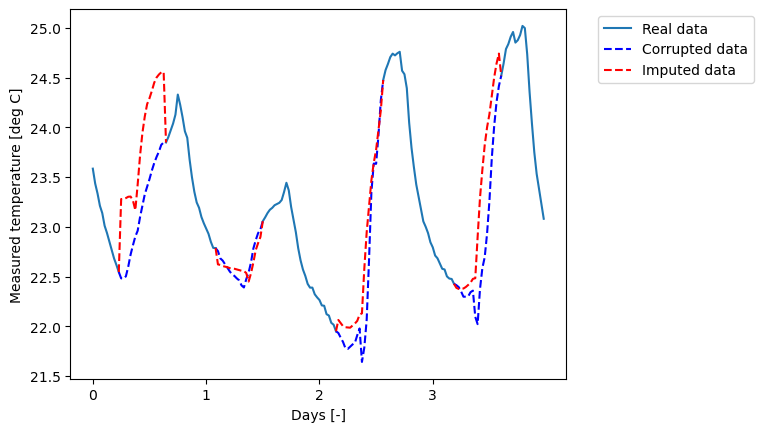

In [26]:
# Draw the first four days. Use the predefined function draw.
draw(file='autoencoder_results.xlsx')